In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import xarray as xr
from xarray_selafin.xarray_backend import SelafinBackendEntrypoint

In [5]:
# parse noaa data
noaa_data = []
with open('id(1).txt','r') as f:
    lines = f.readlines()


    # skip headers
    for line in lines:
        if line.startswith('2020/'):
            parts = line.split()
            date = parts[0]
            time = parts[2]
            pred = float(parts[3])
            high_low = parts[4]
            noaa_data.append({'date':date, 'time':time, 
                                'pred':pred, 'type': high_low})

noaa_df = pd.DataFrame(noaa_data)

In [7]:
# calculate noaa tidal range 
highs = noaa_df[noaa_df['type'] == 'H']['pred'].values
lows = noaa_df[noaa_df['type'] == 'L']['pred'].values

noaa_max_high = np.max(highs)
noaa_min_low = np.min(lows)
noaa_tidal_range = noaa_max_high - noaa_min_low

print("=== NOAA South Freeport Station ===")
print(f"Max High: {noaa_max_high:.2f}m")
print(f"Min Low: {noaa_min_low:.2f}m")
print(f"Tidal Range: {noaa_tidal_range:.2f}m")
print(f"Mean High: {np.mean(highs):.2f}m")
print(f"Mean Low: {np.mean(lows):.2f}m")

=== NOAA South Freeport Station ===
Max High: 3.51m
Min Low: -0.59m
Tidal Range: 4.10m
Mean High: 2.86m
Mean Low: 0.09m


In [9]:
# selafin import (ignore IPOBO array warning)

ds = xr.open_dataset('3DWolfsCoveApr20.slf', engine='selafin')

The IPOBO array seems corrupted (zeros array). Try to rebuild it with `build_ipobo()`.


In [18]:
tel_node_idx0 = 878
z_surface_uncorrected = ds.Z.isel(node=tel_node_idx0, plan=-1).values # top layer of the node
z_surface = z_surface_uncorrected[144:]

tele_max = np.max(z_surface)
tele_min = np.min(z_surface)
tele_tidal = tele_max - tele_min

print("\n=== TELEMAC Node 878 (near tide station) ===")
print(f"Max elevation: {tele_max:.2f}m")
print(f"Min elevation: {tele_min:.2f}m")
print(f"Tidal Range: {tele_tidal:.2f}m")


=== TELEMAC Node 878 (near tide station) ===
Max elevation: 3.82m
Min elevation: 0.70m
Tidal Range: 3.12m


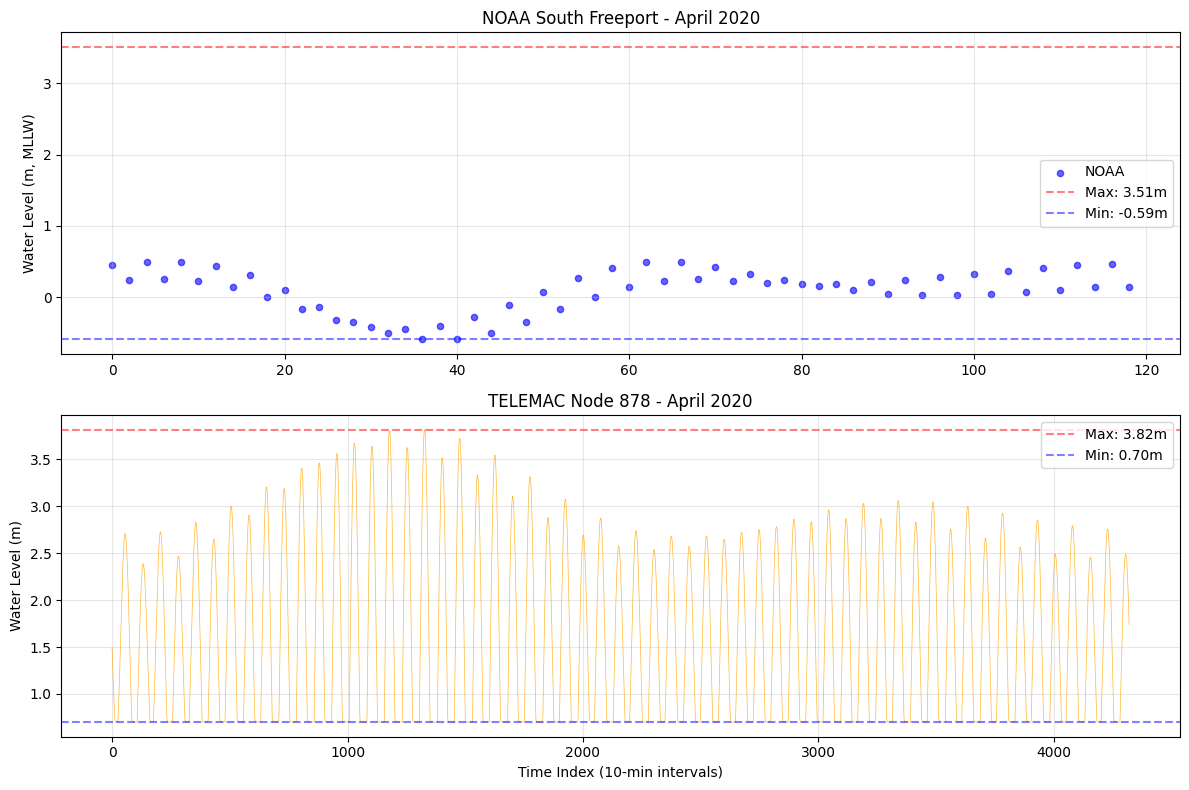

In [19]:
import matplotlib.pyplot as plt

# Time series comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# NOAA data (high/low only)
noaa_times = range(len(noaa_df))
ax1.scatter(noaa_times[::2], noaa_df['pred'].values[::2], 
            c='blue', marker='o', s=20, alpha=0.6, label='NOAA')
ax1.axhline(noaa_max_high, color='r', linestyle='--', alpha=0.5, label=f'Max: {noaa_max_high:.2f}m')
ax1.axhline(noaa_min_low, color='b', linestyle='--', alpha=0.5, label=f'Min: {noaa_min_low:.2f}m')
ax1.set_ylabel('Water Level (m, MLLW)')
ax1.set_title('NOAA South Freeport - April 2020')
ax1.legend()
ax1.grid(True, alpha=0.3)

# TELEMAC data (full time series)
telemac_times = range(len(z_surface))
ax2.plot(telemac_times, z_surface, 'orange', linewidth=0.5, alpha=0.8)
ax2.axhline(tele_max, color='r', linestyle='--', alpha=0.5, label=f'Max: {tele_max:.2f}m')
ax2.axhline(tele_min, color='b', linestyle='--', alpha=0.5, label=f'Min: {tele_min:.2f}m')
ax2.set_ylabel('Water Level (m)')
ax2.set_xlabel('Time Index (10-min intervals)')
ax2.set_title('TELEMAC Node 878 - April 2020')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tidal_validation.png', dpi=300, bbox_inches='tight')
plt.show()

=== After corrections ===
NOAA range: 4.10m
TELEMAC range: 3.12m


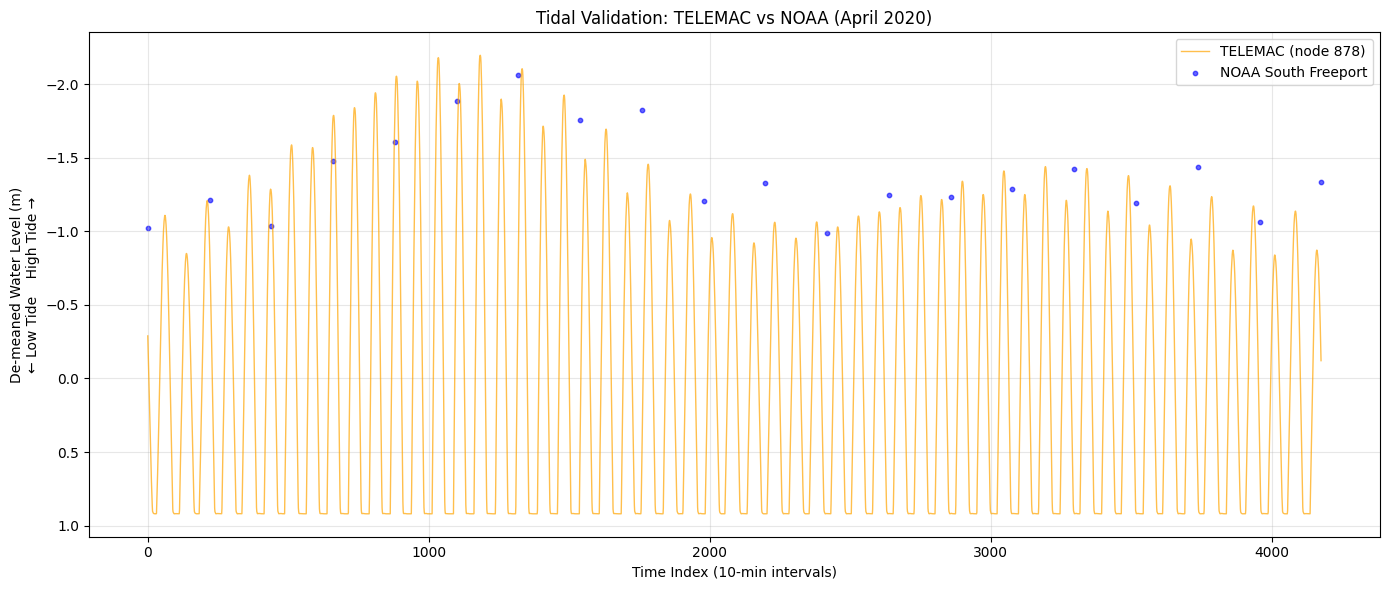

In [28]:
# Remove spin-up (first day = 144 timesteps at 10min intervals)
z_surface_trimmed = z_surface[144:]

# Flip sign (depth → elevation)
z_corrected = -z_surface_trimmed

# De-mean both to compare tidal oscillation
noaa_pred = noaa_df['pred'].values
noaa_demean = noaa_pred - noaa_pred.mean()

telemac_demean = z_corrected - z_corrected.mean()

print("=== After corrections ===")
print(f"NOAA range: {noaa_demean.max() - noaa_demean.min():.2f}m")
print(f"TELEMAC range: {telemac_demean.max() - telemac_demean.min():.2f}m")

# Plot de-meaned comparison
fig, ax = plt.subplots(figsize=(14, 6))

# Subsample NOAA to match TELEMAC resolution (~every 6 points)
noaa_subsample = noaa_demean[::6]
noaa_times = np.linspace(0, len(telemac_demean), len(noaa_subsample))

ax.plot(telemac_demean, 'orange', linewidth=1, alpha=0.7, label='TELEMAC (node 878)')
ax.scatter(noaa_times, noaa_subsample, c='blue', s=10, alpha=0.6, label='NOAA South Freeport')

ax.set_xlabel('Time Index (10-min intervals)')
ax.set_ylabel('De-meaned Water Level (m)\n← Low Tide    High Tide →')
ax.set_title('Tidal Validation: TELEMAC vs NOAA (April 2020)')
ax.invert_yaxis()

ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("tides_comp.png")
plt.show()